# Quick Start

## Step 1: Setting Up

### 1.1 Install Requirements

In [1]:
import os
if not os.getcwd().endswith("automated-ai-innovator"):
    !git clone https://github.com/tig-foundation/automated-ai-innovator
    os.chdir("automated-ai-innovator")
!pip install -r requirements.txt

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

### 1.2 Set Global Parameters

In [2]:
NUM_GENERATIONS = 10
CANDIDATES_PER_GENERATION = 5
# number of prompts sent per experiment is: NUM_GENERATIONS * len(agents)

API_KEY = None
if not API_KEY:
    raise ValueError("You must set an API Key for your LLM provider")

### Step 2: Define Your AutoInnovator

An **AutoInnovator** operates in a loop, where each iteration—called a **generation**—produces a set of **candidate algorithms**. The process for each candidate is:

1. **Create Prompt** – Your defined `create_prompt_kwargs` is used to construct a request to send to a Large Language Model (LLM)
   * See https://platform.openai.com/docs/api-reference/responses/create for what can be included in your request
   * See `Context` and `Candidate` classes in [autoinnovator/framework.py](autoinnovator/framework.py) for what historic data you can access
3. **Send Prompt to LLM** – The prompt is submitted to a LLM.
4. **Extract Algorithm Code** – Your defined `extract_algorithm_code` is used to extract algorithm code from the LLM’s response.
5. **Evaluate Algorithm** – The candidate algorithm is tested and scored.

Each candidate is generated independently but has access to the full history of prior generations. The goal is to design your AutoInnovator in a way that uses data from previous generations to guide the creation of higher-performing algorithms over generations.

> ⚠️ **Important:** The AutoInnovator should not directly edit or mutate algorithms. Instead, it evolves its approach by refining prompts and strategies for generating new candidates.


In [3]:
from autoinnovator import AutoInnovatorBase, Candidate, Context
from typing import Optional
import os

class SimpleAutoInnovator(AutoInnovatorBase):
    def create_prompt_kwargs(self, agent: str, ctx: Context) -> Optional[dict]:
        if ctx.curr_generation == 1:
            prev_candidate = ctx.candidates[0][None] # 0th gen has no agent
        else:
            prev_candidate = ctx.candidates[ctx.curr_generation - 1][agent] # just use previous candidate from this agent
        if not prev_candidate.success:
            # Another strategy would be to use the previous generation's best candidate
            raise RuntimeError("Previous candidate was not successful. Simple Innovator strategy cannot continue.")
        algorithm = prev_candidate.algorithm
        response = prev_candidate.response

        if response:
            text = response["choices"][0]["message"]["content"]
            reasoning = text.split('<reasoning>')[1].split('</reasoning>')[0]
        elif ctx.curr_generation == 1:
            reasoning = "No reasoning yet. Evaluation was on base algorithm."
        else:
            raise RuntimeError("Response does not contain valid reasoning.")
        evaluation = prev_candidate.evaluation
        evaluation["algorithm_code_length"] = len(algorithm)
        
        prompt = {
            "messages": [
                {"role": "user", "content": f"ALGORITHM:\n{algorithm}\nREASONING:\n{reasoning}\nEVALUATION:\n{evaluation}"}
            ],
            "temperature": 1.0,
        }

        return prompt

    def extract_algorithm_code(self, agent: str, ctx: Context) -> Optional[str]:
        text = ctx.candidates[-1][agent].response["choices"][0]["message"]["content"]

        if "<python>" in text and "</python>" in text:
            return text.split("<python>")[1].split("</python>")[0].strip()
        raise ValueError("Response does not contain valid algorithm code.")

## Step 3: Run Your AutoInnovator on the Challenges

We’ve provided **three built-in challenges** to test your AutoInnovator:

1. **KDE** – Generate parameters for a Gaussian Mixture Model that best fits samples drawn from an intractable target distribution.
2. **Binning** – Generate histogram bin edges within the interval $[-1, 1]$ that best represent samples from an intractable target distribution over $[-1, 1]$.
3. **Clustering** – Assign samples from an intractable target distribution into $K$ clusters (where $K$ is provided) to maximize the **pairwise cluster connectivity score**.

> ⚠️ You should not modify the challenges themselves when developing your AutoInnovator. However, you’re welcome to inspect the challenge code to better understand the setup.

### Challenge Code Structure

Each challenge is organized into the following components:
1. `challenges/<challenge_name>.py` → Defines the challenge as an executable Python script.
2. `challenges/configs/<challenge_name>.json` → Specifies configuration settings for generating challenge instances.  Each candidate is evaluated against the same fixed set of instances.
3. `challenges/base_algos/<challenge_name>_<algo_name>.py` → Provides a baseline algorithm implementation for solving challenge instances.


### 3.1 Running KDE Challenge

### Generation 4 - Best Candidate from Agent agent2

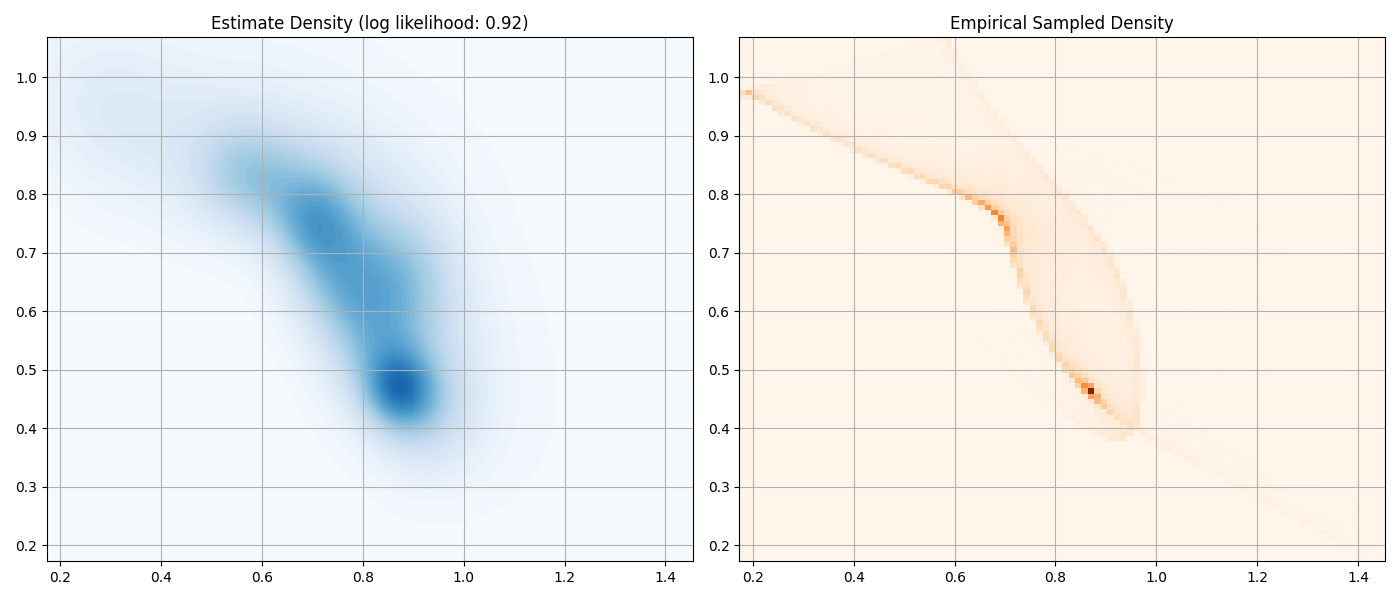

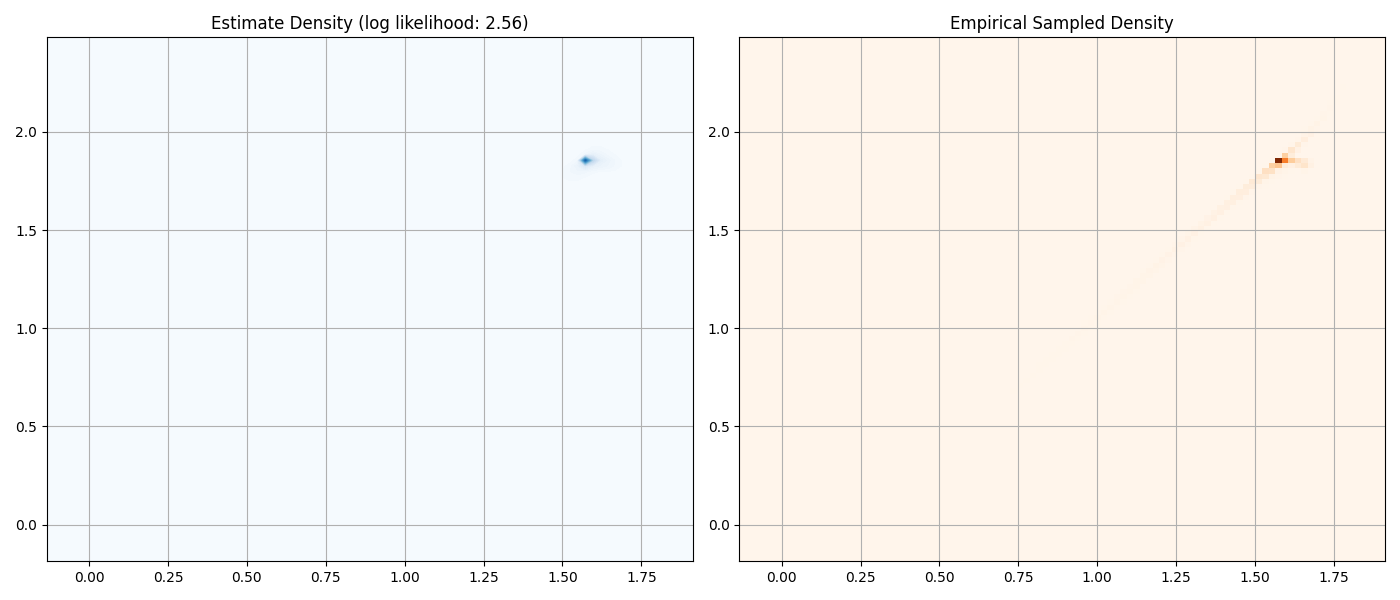

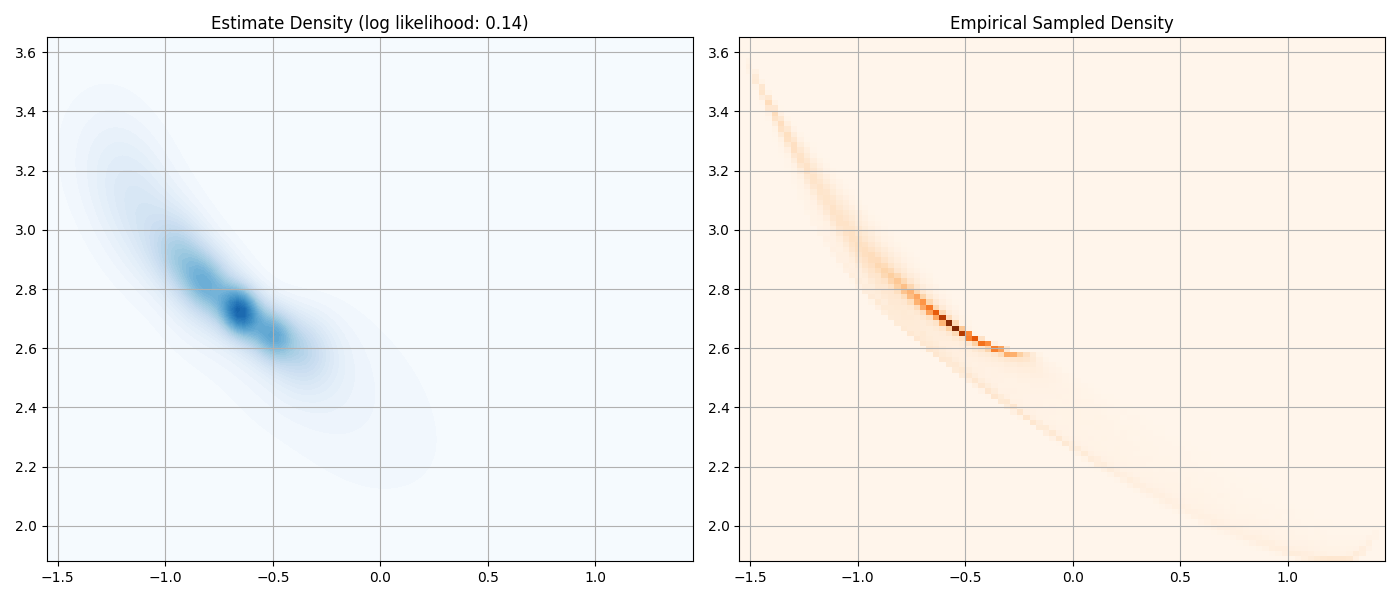

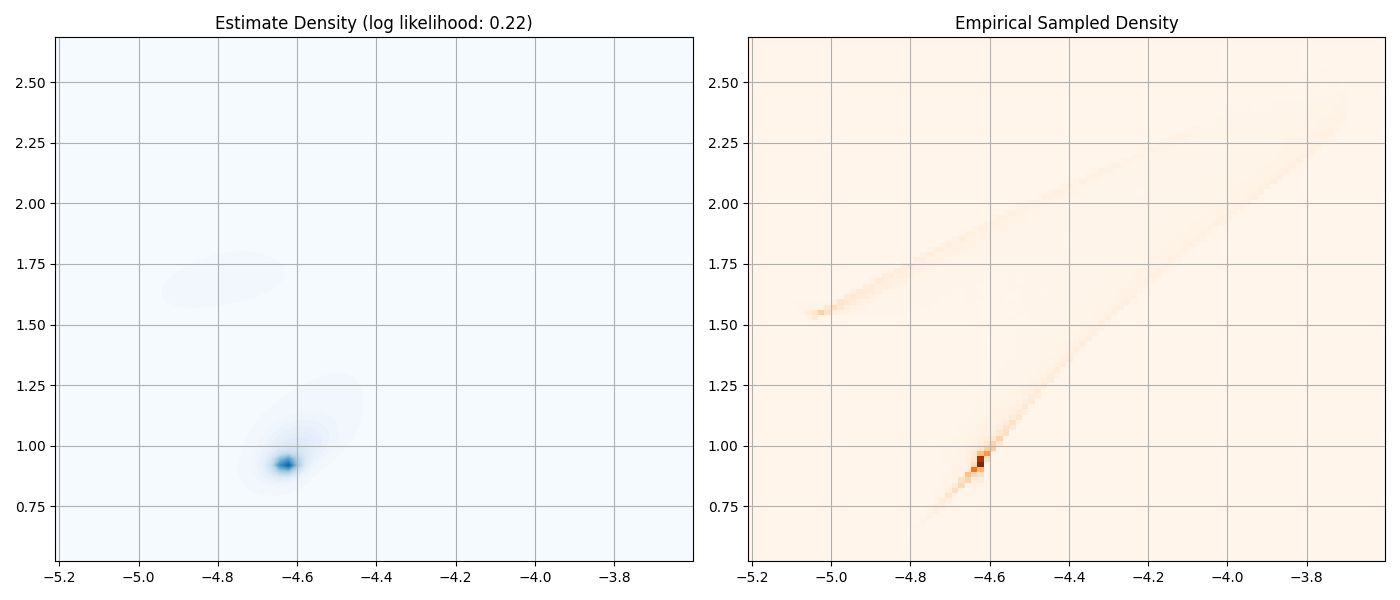

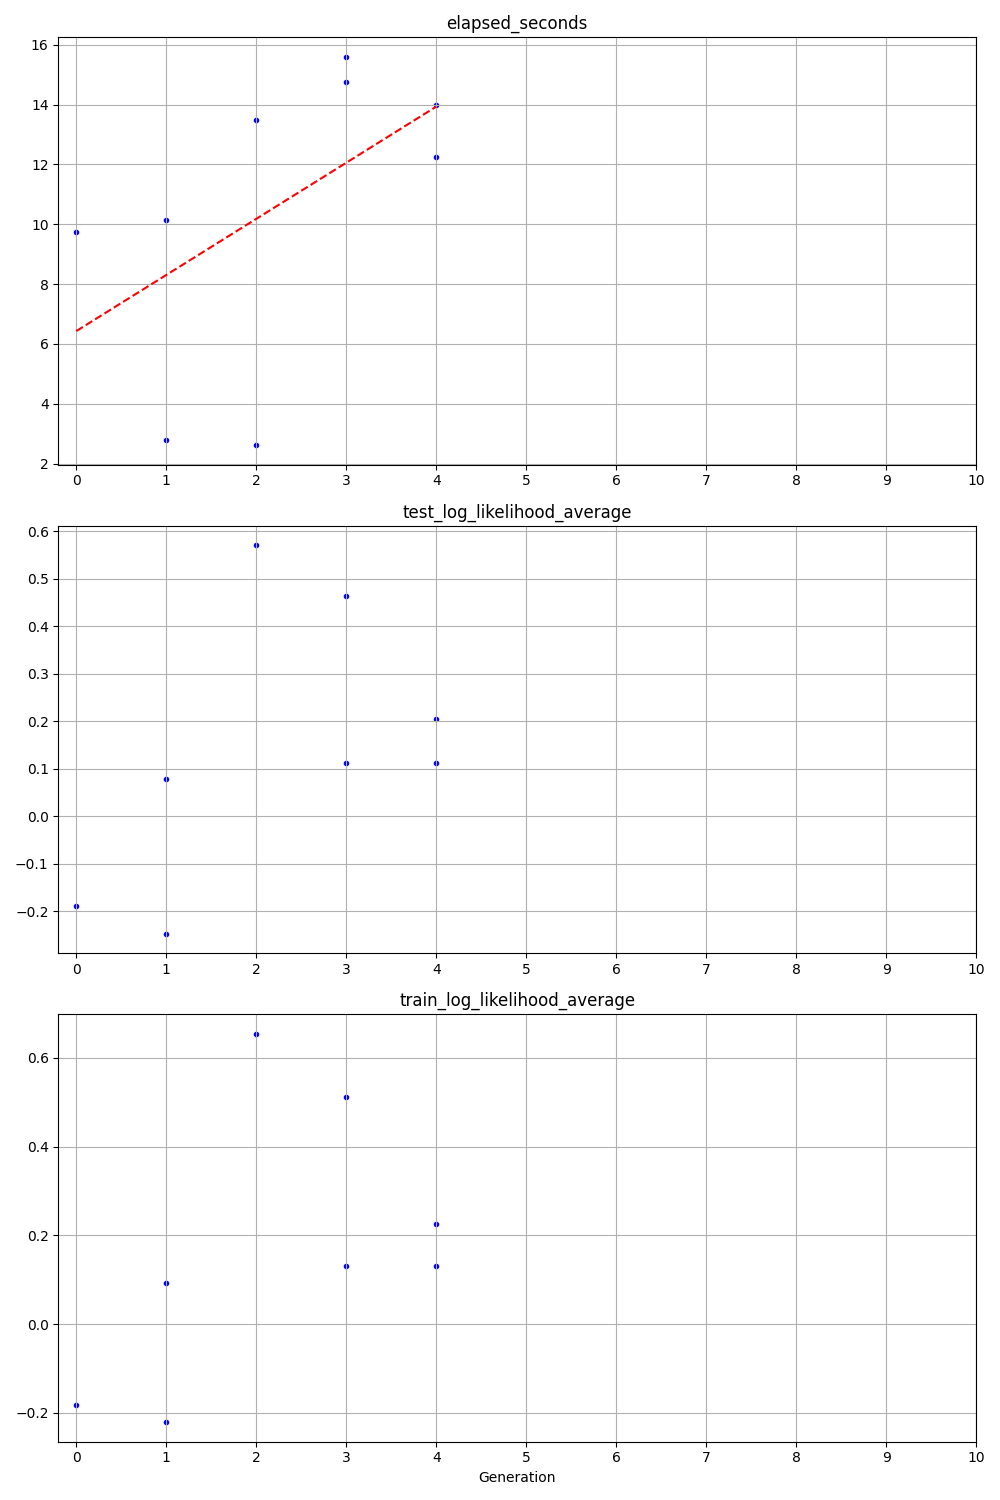

Running generation 5
Gen 5, Agent agent1: create_prompt_kwargs (starting)
Gen 5, Agent agent2: create_prompt_kwargs (starting)
Gen 5, Agent agent1: create_prompt_kwargs (done, took 0.02 seconds)
Gen 5, Agent agent1: llm.send_prompt (starting)
Gen 5, Agent agent2: create_prompt_kwargs (done, took 0.02 seconds)
Gen 5, Agent agent2: llm.send_prompt (starting)
Gen 5, Agent agent1: llm.send_prompt (done, took 6.00 seconds)
Gen 5, Agent agent1: extract_algorithm_code (starting)
Gen 5, Agent agent1: extract_algorithm_code (done, took 0.02 seconds)
Gen 5, Agent agent1: evaluate_algorithm (starting)
Gen 5, Agent agent2: llm.send_prompt (done, took 13.74 seconds)
Gen 5, Agent agent2: extract_algorithm_code (starting)
Gen 5, Agent agent2: extract_algorithm_code (done, took 0.04 seconds)
Gen 5, Agent agent2: evaluate_algorithm (starting)


In [ ]:
from autoinnovator import Challenge, LLM, LLMProvider
from IPython.display import Image, display, clear_output, Markdown
import time

num_visualisations = 4
def on_generation_done(ctx: Context):
    clear_output(wait=True)
    best_candidate = max(
        filter(lambda c: c.success, ctx.candidates[ctx.curr_generation].values()),
        key=lambda c: c.evaluation["test_log_likelihood_average"]
    )
    display(Markdown(f"### Generation {ctx.curr_generation} - Best Candidate from Agent '{best_candidate.agent}'"))
    for i in range(num_visualisations):
        display(Image(filename=best_candidate.visualisation_path.format(i=i)))
    display(Image(filename=ctx.results_plot_path))
    time.sleep(1)

challenge = Challenge("kde")
kde_ctx = SimpleAutoInnovator().run(
    agents=dict(
        agent1=LLM(
            provider=LLMProvider.OPENAI,
            model="gpt-4.1-mini-2025-04-14",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        ),
        agent2=LLM(
            provider=LLMProvider.OPENAI,
            model="o3-mini-2025-01-31",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        )
    ),
    challenge=challenge,
    num_generations=NUM_GENERATIONS,
    experiment_dir=os.path.join("experiments", challenge.name),
    num_visualisations_per_candidate=num_visualisations,
    on_generation_done=on_generation_done
)

### 3.2 Running Binning Challenge

In [ ]:
from IPython.display import Image, display, clear_output, Markdown
import time

num_visualisations = 4
def on_generation_done(ctx: Context):
    clear_output(wait=True)
    best_candidate = max(
        filter(lambda c: c.success, ctx.candidates[ctx.curr_generation].values()),
        key=lambda c: c.evaluation["test_log_likelihood_average"]
    )
    display(Markdown(f"### Generation {ctx.curr_generation} - Best Candidate from Agent '{best_candidate.agent}'"))
    for i in range(num_visualisations):
        display(Image(filename=best_candidate.visualisation_path.format(i=i)))
    display(Image(filename=ctx.results_plot_path))
    time.sleep(1)

challenge = Challenge("binning")
binning_ctx = SimpleAutoInnovator().run(
    agents=dict(
        agent1=LLM(
            provider=LLMProvider.OPENAI,
            model="gpt-4.1-mini-2025-04-14",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        ),
        agent2=LLM(
            provider=LLMProvider.OPENAI,
            model="o3-mini-2025-01-31",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        )
    ),
    challenge=challenge,
    num_generations=NUM_GENERATIONS,
    experiment_dir=os.path.join("experiments", challenge.name),
    num_visualisations_per_candidate=num_visualisations,
    on_generation_done=on_generation_done
)

### 3.3 Running Clustering Challenge

In [ ]:
from IPython.display import Image, display, clear_output, Markdown
import time

num_visualisations = 4
def on_generation_done(ctx: Context):
    clear_output(wait=True)
    best_candidate = min(
        filter(lambda c: c.success, ctx.candidates[ctx.curr_generation].values()),
        key=lambda c: c.evaluation["cluster_scores_average"]
    )
    display(Markdown(f"### Generation {ctx.curr_generation} - Best Candidate from Agent '{best_candidate.agent}'"))
    for i in range(num_visualisations):
        display(Image(filename=best_candidate.visualisation_path.format(i=i)))
    display(Image(filename=ctx.results_plot_path))
    time.sleep(1)

challenge = Challenge("clustering")
clustering_ctx = SimpleAutoInnovator().run(
    agents=dict(
        agent1=LLM(
            provider=LLMProvider.OPENAI,
            model="gpt-4.1-mini-2025-04-14",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        ),
        agent2=LLM(
            provider=LLMProvider.OPENAI,
            model="o3-mini-2025-01-31",
            api_key=API_KEY,
            secret_messages=[
                {"role": "system", "content": open(os.path.join("example_prompts", f"{challenge.name}.txt"), "r").read().format(parameters=challenge.parameters)}
            ]
        )
    ),
    challenge=challenge,
    num_generations=NUM_GENERATIONS,
    experiment_dir=os.path.join("experiments", challenge.name),
    num_visualisations_per_candidate=num_visualisations,
    on_generation_done=on_generation_done
)